In [1]:
!pip install -qq "arize-phoenix[eval,llama-index]" "openai>=1" pyvis datasets pycm requests

In [1]:
import os
from getpass import getpass

if not (openai_api_key := os.getenv("OPENAI_API_KEY")):
    openai_api_key = getpass("🔑 Enter your OpenAI API key: ")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [2]:
# Standard library imports
import re

# Third-party library imports
from typing import Any, Dict, List, Optional, Set, Tuple, cast

import nest_asyncio
import pandas as pd
import phoenix as px

# Local module imports
from llama_index.core import SQLDatabase
from llama_index.core.agent import (
    AgentChatResponse,
    AgentRunner,
    QueryPipelineAgentWorker,
    ReActChatFormatter,
    Task,
)
from llama_index.core.agent.react.output_parser import ReActOutputParser
from llama_index.core.agent.react.types import (
    ObservationReasoningStep,
    ResponseReasoningStep,
)
from llama_index.core.llms import ChatMessage, MessageRole
from llama_index.core.query_engine import NLSQLTableQueryEngine
from llama_index.core.query_pipeline import (
    AgentFnComponent,
    AgentInputComponent,
    CustomAgentComponent,
    QueryComponent,
    QueryPipeline,
    ToolRunnerComponent,
)
from llama_index.core.tools import BaseTool, QueryEngineTool
from llama_index.llms.openai import OpenAI
from sqlalchemy import create_engine
from tqdm import tqdm

# Apply settings and initializations
pd.set_option("display.max_colwidth", 1000)
nest_asyncio.apply()

In [3]:
import os
import tempfile
import zipfile
from io import BytesIO

import matplotlib.pyplot as plt
import pandas as pd
import requests

In [4]:
from phoenix.evals import (
    SQL_GEN_EVAL_PROMPT_RAILS_MAP,
    SQL_GEN_EVAL_PROMPT_TEMPLATE,
    OpenAIModel,
    llm_classify,
)
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

temp_dir = tempfile.mkdtemp()
url = "https://www.sqlitetutorial.net/wp-content/uploads/2018/03/chinook.zip"
with zipfile.ZipFile(BytesIO(requests.get(url).content), "r") as f:
    f.extractall(temp_dir)
engine = create_engine(f"sqlite:///{os.path.join(temp_dir, 'chinook.db')}")
sql_database = SQLDatabase(engine)

In [5]:
session = px.launch_app()

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [6]:
from openinference.instrumentation.llama_index import LlamaIndexInstrumentor
from opentelemetry.exporter.otlp.proto.http.trace_exporter import OTLPSpanExporter
from opentelemetry.sdk.trace import TracerProvider
from opentelemetry.sdk.trace.export import SimpleSpanProcessor

endpoint = "http://127.0.0.1:6006/v1/traces"
tracer_provider = TracerProvider()
tracer_provider.add_span_processor(SimpleSpanProcessor(OTLPSpanExporter(endpoint)))

LlamaIndexInstrumentor().instrument(tracer_provider=tracer_provider)

In [7]:
sql_query_engine = NLSQLTableQueryEngine(
    sql_database=sql_database,
    tables=["albums", "tracks", "artists"],
    verbose=True,
)
sql_tool = QueryEngineTool.from_defaults(
    query_engine=sql_query_engine,
    name="sql_tool",
    description=("Useful for translating a natural language query into a SQL query"),
)

In [8]:
questions = [
    "What is the name of the artist with ID 5?",
    "List all tracks in the album with ID 3.",
    "How many tracks does the artist named 'Aerosmith' have?",
    "Find the oldest song in the database.",
    "What is the duration of the track with ID 10?",
    "List the names of all albums released in 2020.",
    "How many artists are in the database?",
    "Which artist has the most tracks in the database?",
    "List all tracks in the 'Pop' genre.",
    "What is the average length of tracks in the database?",
    "Find the most recent track.",
    "List the top 5 longest tracks in the database.",
    "Which album has the highest number of tracks?",
    "List all artists who have released more than 3 albums.",
    "What is the shortest track in the database?",
    "Find all albums released by 'The Beatles'.",
    "How many tracks are in the 'Rock' genre?",
    "List the names of all tracks released before 2000.",
    "What is the total duration of the album with ID 7?",
    "Find the artist who released the album 'Thriller'.",
    "List the names of all albums by 'Pink Floyd'.",
    "How many albums have been released between 1990 and 2000?",
    "What genres are covered by the artist 'David Bowie'?",
    "List the top 10 most played tracks.",
    "Which artist has the longest total track duration in the database?",
    "Find all tracks with a duration longer than 5 minutes.",
    "How many tracks does each album contain on average?",
    "List all albums sorted by release date.",
    "Which artist's albums have the highest average ratings?",
    "Find the total duration of all tracks by 'Michael Jackson'.",
    "How many tracks in the database are instrumental?",
    "List the names of all tracks by artists with the name starting with 'J'.",
    "What is the most common genre in the database?",
    "Find the average album length in minutes.",
    "How many artists have only one album in the database?",
    "List all tracks from the album with the most number of tracks.",
    "Which artist has released the most albums?",
    "Find the total number of tracks produced by 'Eminem'.",
    "How many albums in the database have no tracks?",
    "List the name and duration of the longest track in each album.",
    "What is the average number of tracks per album?",
    "Find all albums that have more than 10 tracks.",
    "How many tracks in the database are longer than the average track length?",
    "List the albums released by the artist with the most albums.",
    "Which year has the highest number of album releases?",
    "Find the total playtime of all tracks in the 'Jazz' genre.",
    "How many artists have names longer than 10 characters?",
    "List all song genres found in the database.",
    "What is the average track length of the tracks?",
    "How many albums were released on average by each artist?",
]

print(questions)

['What is the name of the artist with ID 5?', 'List all tracks in the album with ID 3.', "How many tracks does the artist named 'Aerosmith' have?"]


In [9]:
## Agent Input Component
## This is the component that produces agent inputs to the rest of the components
## Can also put initialization logic here.


def agent_input_fn(task: Task, state: Dict[str, Any]) -> Dict[str, Any]:
    """Agent input function.

    Returns:
        A Dictionary of output keys and values. If you are specifying
        src_key when defining links between this component and other
        components, make sure the src_key matches the specified output_key.

    """
    # initialize current_reasoning
    if "current_reasoning" not in state:
        state["current_reasoning"] = []
    reasoning_step = ObservationReasoningStep(observation=task.input)
    state["current_reasoning"].append(reasoning_step)
    return {"input": task.input}


agent_input_component = AgentInputComponent(fn=agent_input_fn)

In [10]:
## define prompt function


def react_prompt_fn(
    task: Task, state: Dict[str, Any], input: str, tools: List[BaseTool]
) -> List[ChatMessage]:
    # Add input to reasoning
    chat_formatter = ReActChatFormatter()
    return chat_formatter.format(
        tools,
        chat_history=task.memory.get() + state["memory"].get_all(),
        current_reasoning=state["current_reasoning"],
    )


react_prompt_component = AgentFnComponent(fn=react_prompt_fn, partial_dict={"tools": [sql_tool]})

In [11]:
## Agent Output Component
## Process reasoning step/tool outputs, and return agent response


def finalize_fn(
    task: Task,
    state: Dict[str, Any],
    reasoning_step: Any,
    is_done: bool = False,
    tool_output: Optional[Any] = None,
) -> Tuple[AgentChatResponse, bool]:
    """Finalize function.

    Here we take the latest reasoning step, and a tool output (if provided),
    and return the agent output (and decide if agent is done).

    This function returns an `AgentChatResponse` and `is_done` tuple. and
    is the last component of the query pipeline. This is the expected
    return type for any query pipeline passed to `QueryPipelineAgentWorker`.

    """
    current_reasoning = state["current_reasoning"]
    current_reasoning.append(reasoning_step)
    # if tool_output is not None, add to current reasoning
    if tool_output is not None:
        observation_step = ObservationReasoningStep(observation=str(tool_output))
        current_reasoning.append(observation_step)
    if isinstance(current_reasoning[-1], ResponseReasoningStep):
        response_step = cast(ResponseReasoningStep, current_reasoning[-1])
        response_str = response_step.response
    else:
        response_str = current_reasoning[-1].get_content()

    # if is_done, add to memory
    # NOTE: memory is a reserved keyword in `state`, but you can add your own too
    if is_done:
        state["memory"].put(ChatMessage(content=task.input, role=MessageRole.USER))
        state["memory"].put(ChatMessage(content=response_str, role=MessageRole.ASSISTANT))

    return AgentChatResponse(response=response_str), is_done


class OutputAgentComponent(CustomAgentComponent):
    """Output agent component."""

    tool_runner_component: ToolRunnerComponent
    output_parser: ReActOutputParser

    def __init__(self, tools, **kwargs):
        tool_runner_component = ToolRunnerComponent(tools)
        super().__init__(
            tool_runner_component=tool_runner_component, output_parser=ReActOutputParser(), **kwargs
        )

    def _run_component(self, **kwargs: Any) -> Any:
        """Run component."""
        chat_response = kwargs["chat_response"]
        task = kwargs["task"]
        state = kwargs["state"]
        reasoning_step = self.output_parser.parse(chat_response.message.content)
        if reasoning_step.is_done:
            return {"output": finalize_fn(task, state, reasoning_step, is_done=True)}
        else:
            tool_output = self.tool_runner_component.run_component(
                tool_name=reasoning_step.action,
                tool_input=reasoning_step.action_input,
            )
            return {
                "output": finalize_fn(
                    task,
                    state,
                    reasoning_step,
                    is_done=False,
                    tool_output=tool_output,
                )
            }

    @property
    def _input_keys(self) -> Set[str]:
        return {"chat_response"}

    @property
    def _optional_input_keys(self) -> Set[str]:
        return {"is_done", "tool_output"}

    @property
    def _output_keys(self) -> Set[str]:
        return {"output"}

    @property
    def sub_query_components(self) -> List[QueryComponent]:
        return [self.tool_runner_component]


react_output_component = OutputAgentComponent([sql_tool])

In [12]:
qp = QueryPipeline(
    modules={
        "agent_input": agent_input_component,
        "react_prompt": react_prompt_component,
        "llm": OpenAI(model="gpt-4o"),
        "react_output": react_output_component,
    },
    verbose=True,
)
qp.add_chain(["agent_input", "react_prompt", "llm", "react_output"])

In [13]:
agent_worker = QueryPipelineAgentWorker(qp)
agent = AgentRunner(agent_worker)
response = agent.chat("Is Aerosmith in this database?")
print(str(response))

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='b5f91146-3fa5-4129-9af1-57269b4caef3' input='Is Aerosmith in this database?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tok...

> Running module react_prompt with input: 
input: Is Aerosmith in this database?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The user is asking if Aerosmith is in a database, but I don't have direct access to a database to check this information. Howev

In [14]:
all_sql_queries = []
all_ans = []
for question in tqdm(questions):
    agent_worker = QueryPipelineAgentWorker(qp)
    agent = AgentRunner(agent_worker)
    task = agent.create_task(question)
    # Need to manually run the task as to recover the convo_history
    step_output = agent.run_step(task.task_id)
    ans = str(step_output)
    sql_query_match = re.search(r"\'sql_query\': \'([^\']+)\'", ans)

    if not sql_query_match:
        print(ans)
    # Extract the sql_query if the pattern is found
    sql_query = sql_query_match.group(1) if sql_query_match else None

    # Regular expression to extract the response
    response_match = re.search(r"response=\'([^\']+)\'", ans)

    # Extract the response if the pattern is found
    response = response_match.group(1) if response_match else None

    print("SQL Query:", sql_query)
    print("Response:", response)
    all_ans.append(response)
    all_sql_queries.append(sql_query)

  0%|          | 0/3 [00:00<?, ?it/s]

> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='3b2ae15a-71ad-47ad-816c-7544925458e7' input='What is the name of the artist with ID 5?' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limi...

> Running module react_prompt with input: 
input: What is the name of the artist with ID 5?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The current language of the user is English. I need to use a tool to help me answer the question.
Action: sql_tool
A

 33%|███▎      | 1/3 [00:04<00:09,  4.50s/it]

SQL Query: SELECT Name\nFROM artists\nWHERE ArtistId = 5;
Response: The artist with ID 5 is Alice In Chains.
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='d7cd70c9-e23b-4c0f-a810-ea1fb4e48d45' input='List all tracks in the album with ID 3.' memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=...

> Running module react_prompt with input: 
input: List all tracks in the album with ID 3.

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n\n...

> Running module react_output with input: 
chat_response: assistant: Thought: The curre

 67%|██████▋   | 2/3 [00:12<00:06,  6.28s/it]

SQL Query: SELECT Name\nFROM tracks\nWHERE AlbumId = 3\nORDER BY Name;
Response: The tracks in the album with ID 3 are "Fast As a Shark", "Princess of the Dawn", and "Restless and Wild".
> Running module agent_input with input: 
state: {'sources': [], 'memory': ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_history', token_limit=3000, tokenizer_fn=functools.partial(<bound method Encoding.encode of <Encod...
task: task_id='ba8cef26-5704-4149-97c8-b3db57b8413a' input="How many tracks does the artist named 'Aerosmith' have?" memory=ChatMemoryBuffer(chat_store=SimpleChatStore(store={}), chat_store_key='chat_histor...

> Running module react_prompt with input: 
input: How many tracks does the artist named 'Aerosmith' have?

> Running module llm with input: 
messages: [ChatMessage(role=<MessageRole.SYSTEM: 'system'>, content='You are designed to help with a variety of tasks, from answering questions to providing summaries to other types of analyses.\n\n## Tools\n

100%|██████████| 3/3 [00:16<00:00,  5.44s/it]

Observation: {'output': ToolOutput(content="The artist named 'Aerosmith' has a total of 15 tracks.", tool_name='sql_tool', raw_input={'input': "How many tracks does the artist named 'Aerosmith' have?"}, raw_output=Response(response="The artist named 'Aerosmith' has a total of 15 tracks.", source_nodes=[NodeWithScore(node=TextNode(id_='24f28ef3-7c72-4f8d-ba99-ef289a2029e9', embedding=None, metadata={}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, text='[(15,)]', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n'), score=None)], metadata={'24f28ef3-7c72-4f8d-ba99-ef289a2029e9': {}, 'sql_query': "SELECT COUNT(tracks.TrackId) AS NumTracks\nFROM tracks\nJOIN albums ON tracks.AlbumId = albums.AlbumId\nJOIN artists ON albums.ArtistId = artists.ArtistId\nWHERE artists.Name = 'Aerosmith'", 'result': [(15,)], 'col_keys': ['NumTracks']}), is_error=False)}
SQL Query: N

In [15]:
df = pd.DataFrame({"question": questions, "query_gen": all_sql_queries, "response": all_ans})
df[:3]

,question,query_gen,response
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.
1,List all tracks in the album with ID 3.,SELECT Name\nFROM tracks\nWHERE AlbumId = 3\nORDER BY Name;,"The tracks in the album with ID 3 are ""Fast As a Shark"", ""Princess of the Dawn"", and ""Restless and Wild""."
2,How many tracks does the artist named 'Aerosmith' have?,None,None


In [16]:
print(SQL_GEN_EVAL_PROMPT_TEMPLATE)


SQL Evaluation Prompt:
-----------------------
You are tasked with determining if the SQL generated appropiately answers a given instruction
taking into account its generated query and response.

Data:
-----
- [Instruction]: {question}
  This section contains the specific task or problem that the sql query is intended to solve.

- [Reference Query]: {query_gen}
  This is the sql query submitted for evaluation. Analyze it in the context of the provided
  instruction.

- [Provided Response]: {response}
  This is the response and/or conclusions made after running the sql query through the database

Evaluation:
-----------
Your response should be a single word: either "correct" or "incorrect".
You must assume that the db exists and that columns are appropiately named.
You must take into account the response as additional information to determine the correctness.

- "correct" indicates that the sql query correctly solves the instruction.
- "incorrect" indicates that the sql query correctly

In [17]:
df.rename(columns={"query": "question", "sql_query": "query_gen"}, inplace=True)

In [18]:
rails = list(SQL_GEN_EVAL_PROMPT_RAILS_MAP.values())
model = OpenAIModel(
    model_name="gpt-4o",
    temperature=0.0,
)
relevance_classifications = llm_classify(
    dataframe=df,
    template=SQL_GEN_EVAL_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    provide_explanation=True,
)
# relevance_classifications

The `model_name` field is deprecated. Use `model` instead.                 This will be removed in a future release.


llm_classify |          | 0/3 (0.0%) | ⏳ 00:00<? | ?it/s

Retries exhausted after 1 attempts: Missing template variables: query_gen, response


In [19]:
labels = relevance_classifications["label"].tolist()
explanation = relevance_classifications["explanation"].tolist()

In [20]:
df["label"] = labels
df["explanation"] = explanation

In [21]:
df[:2]

,question,query_gen,response,label,explanation
0,What is the name of the artist with ID 5?,SELECT Name\nFROM artists\nWHERE ArtistId = 5;,The artist with ID 5 is Alice In Chains.,None,None
1,List all tracks in the album with ID 3.,SELECT Name\nFROM tracks\nWHERE AlbumId = 3\nORDER BY Name;,"The tracks in the album with ID 3 are ""Fast As a Shark"", ""Princess of the Dawn"", and ""Restless and Wild"".",None,None


In [22]:
boolean_classifications = [x == "correct" for x in df["label"].tolist()]

In [23]:
df["is_correct"] = boolean_classifications

In [25]:
df["ground_truth"] = [
    True,
    True,
    False,
    False,
    True,
    False,
    True,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    True,
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    True,
    True,
    False,
    False,
    False,
    False,
    True,
    False,
    True,
    False,
    True,
    False,
    True,
    True,
    True,
    True,
    True,
    True,
    True,
    False,
    True,
    False,
    True,
    False,
]
true_labels = df["ground_truth"]

              precision    recall  f1-score   support

        True       0.00      0.00      0.00         2
       False       0.33      1.00      0.50         1

    accuracy                           0.33         3
   macro avg       0.17      0.50      0.25         3
weighted avg       0.11      0.33      0.17         3



/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/mambaforge/base/envs/py38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

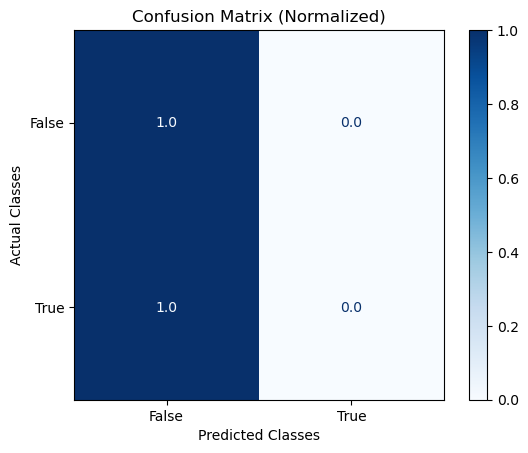

In [26]:
print(classification_report(true_labels, boolean_classifications, labels=[True, False]))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels.tolist(), predict_vector=boolean_classifications
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)